# Importing Libraries and Defining data

In [1]:

import tensorflow as tf
from tensorflow import keras

#Importing tensorflow libs
from keras.preprocessing.image import ImageDataGenerator #image generator label data based on the dir the image in contained in
from keras.optimizers import RMSprop, Adam
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Rescaling, RandomFlip, RandomRotation, RandomZoom
from keras.utils import get_file, image_dataset_from_directory

#Confusion Matrix Libs
from sklearn.metrics import confusion_matrix
import itertools

#Importing general libs
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg
import pathlib
import os
import random
import shutil
import time

### Creating folder for Validation images

In [ ]:
# Creating Val folder
#os.chdir('datasets/chest_xray/chest_xray/')
#if os.path.isdir('val/NORMAL') is False:
#   os.makedirs('val/NORMAL')
#   os.makedirs('val/PNEUMONIA')

# Moving Images from train folder to val folder
source = 'chest_xray/train/PNEUMONIA/'
dest = 'datasets/chest_xray/chest_xray/val/PNEUMONIA'
files = os.listdir(source)
np_of_files = len(files) // 25
for file_name in random.sample(files, np_of_files):
        shutil.move(os.path.join(source, file_name), dest)

# Moving Normal Images from train folder to val folder
source = 'datasets/chest_xray/chest_xray/train/NORMAL/'
dest = 'datasets/chest_xray/chest_xray/val/NORMAL'
files = os.listdir(source)
np_of_files = len(files) // 25
for file_name in random.sample(files, np_of_files):
        shutil.move(os.path.join(source, file_name), dest)

### Setting up plotImages

In [2]:
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(1, 5, figsize=(len(images_arr),len(images_arr)))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% normal")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% pnuemonia")
    plt.show()

### Setting up Confusion Matrix

In [3]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Data Preprocessing and Augmentation

In [6]:
train_dir = "../datasets/chest_xray/chest_xray/train/"
val_dir = "../datasets/chest_xray/chest_xray/val/"
batch_size = 128
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [41]:
train_image_generator = ImageDataGenerator(rescale=1/255)
val_image_generator = ImageDataGenerator(rescale=1/255)

train_datagen = train_image_generator.flow_from_directory(
                                                        train_dir,
                                                        target_size= (IMG_HEIGHT,IMG_WIDTH),
                                                        color_mode='rgb',
                                                        batch_size= batch_size,
                                                        class_mode= 'binary',
                                                        classes=['NORMAL','PNEUMONIA'],
                                                        shuffle= True,
                                                        seed= 42
    )

val_datagen = val_image_generator.flow_from_directory(
                                                        val_dir,
                                                        target_size= (IMG_HEIGHT,IMG_WIDTH),
                                                        color_mode='rgb',
                                                        batch_size= batch_size,
                                                        class_mode= 'binary',
                                                        classes=['NORMAL','PNEUMONIA'],
                                                        shuffle= False,
                                                        seed= 42
    )

Found 3900 images belonging to 2 classes.
Found 1074 images belonging to 2 classes.


[0. 1. 0. 1. 1.]


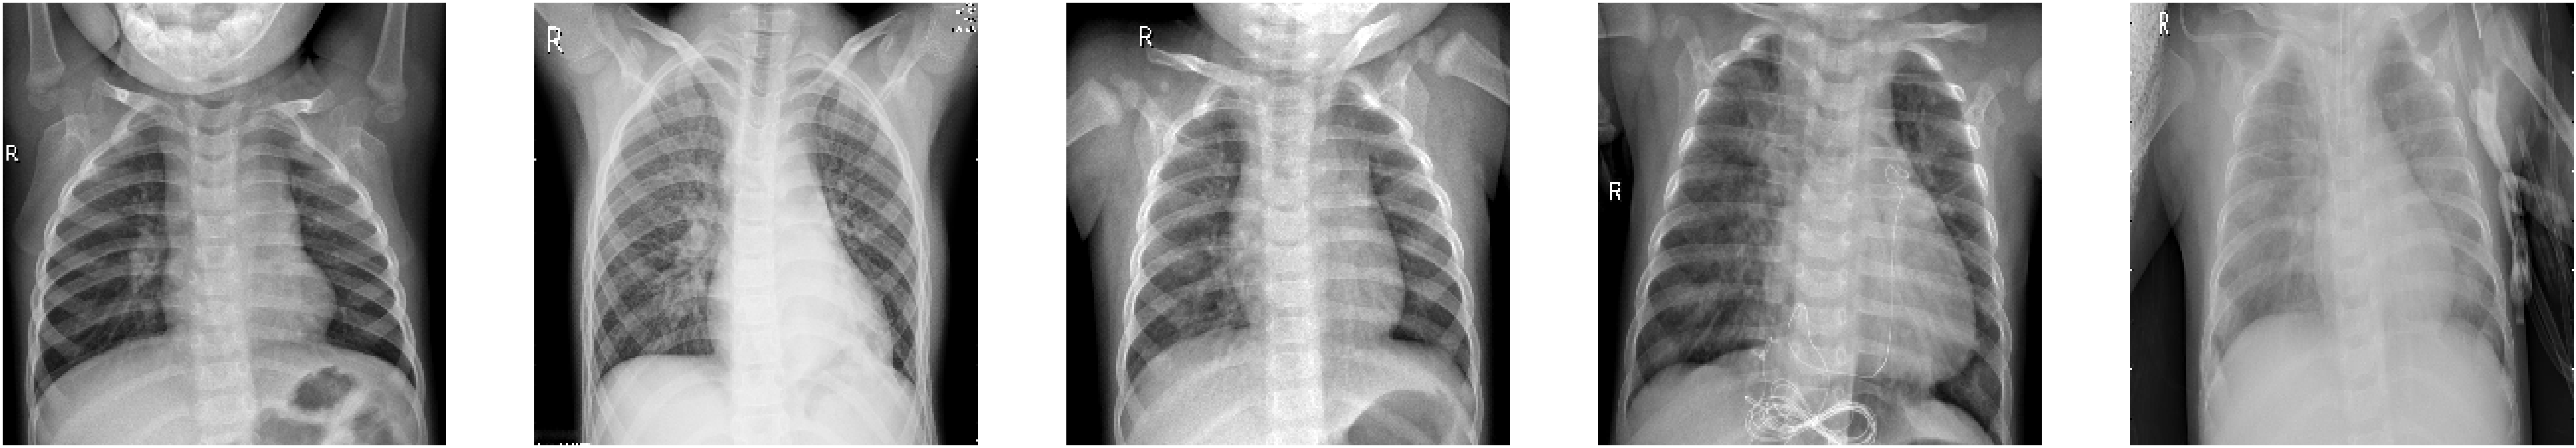

In [16]:
class_names = train_datagen.classes
imgs, class_names = next(train_datagen)
print(class_names[:5])
plotImages(imgs)

In [28]:
train_image_generator = ImageDataGenerator(
    rotation_range= 0.5,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.5,
    rescale= 1./255
)

train_datagen = train_image_generator.flow_from_directory(
    train_dir,
    target_size= (IMG_HEIGHT,IMG_WIDTH),
    color_mode='rgb',
    batch_size= batch_size,
    class_mode= 'binary',
    classes=['NORMAL','PNEUMONIA'],
    shuffle= True,
    seed= 42
    )


Found 3900 images belonging to 2 classes.


[0. 1. 0. 1. 1.]


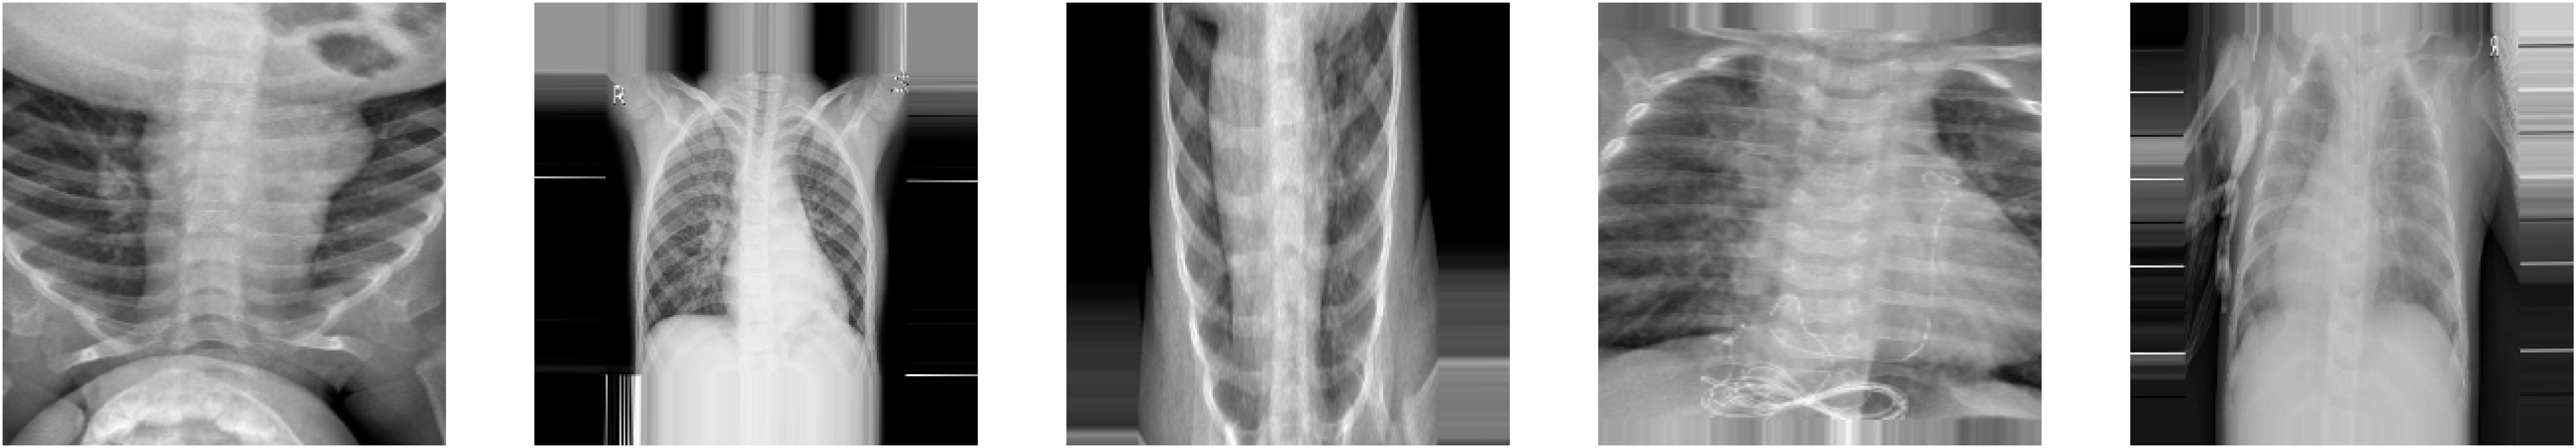

In [29]:
class_names = train_datagen.classes
imgs, class_names = next(train_datagen)
print(class_names[:5])
plotImages(imgs)

# Setting up the CNN

In [42]:
from keras.applications import VGG16

base_model = VGG16(include_top=False, input_shape=(224, 224, 3), weights="imagenet")
base_model.trainable = False
for layer in base_model.layers[:-4]:
    layer.trainable = False

In [49]:
model = Sequential()
model.add(base_model)
model.add(Conv2D(filters=32, kernel_size=3, strides=(2, 2)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=2))
model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(256, activation="relu"))
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation="softmax"))

In [50]:
model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = 'Adam',
    metrics = ['accuracy']
)

In [51]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 conv2d_30 (Conv2D)          (None, 3, 3, 32)          147488    
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 1, 1, 32)          0         
 ng2D)                                                           
                                                                 
 flatten_6 (Flatten)         (None, 32)                0         
                                                                 
 dropout_6 (Dropout)         (None, 32)                0         
                                                                 
 dense_12 (Dense)            (None, 256)               8448      
                                                     

# Fitting Model

In [55]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

currtime = time.strftime("%H%M%S")
callback = EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True, min_delta=0.3
)
reduceLR = ReduceLROnPlateau(
    monitor="val_loss", factor=0.001, patience=3, min_lr=0.0000035
)
checkpoint = ModelCheckpoint(
    filepath=f"../Models/{currtime}_best_{{epoch:02d}}-{{val_loss:.2f}}.hdf5",
    save_weights_only=True,
    monitor="val_accuracy",
    mode="max",
    save_best_only=True,
)

In [58]:
%%time
history = model.fit(
    train_datagen,
    steps_per_epoch = train_datagen.n//train_datagen.batch_size,
    epochs = 10,
    validation_data= val_datagen,
    validation_steps= val_datagen.n//val_datagen.batch_size,
    #callbacks=[callback, reduceLR],
    verbose = 1
)

Epoch 1/10
30/30 [==============================] - 92s 3s/step - loss: 0.0858 - accuracy: 0.9692 - val_loss: 0.1007 - val_accuracy: 0.9648
Epoch 2/10
30/30 [==============================] - 90s 3s/step - loss: 0.1175 - accuracy: 0.9544 - val_loss: 0.1074 - val_accuracy: 0.9580
Epoch 3/10
30/30 [==============================] - 106s 4s/step - loss: 0.0678 - accuracy: 0.9735 - val_loss: 0.0744 - val_accuracy: 0.9717
Epoch 4/10
30/30 [==============================] - 111s 4s/step - loss: 0.0656 - accuracy: 0.9753 - val_loss: 0.0742 - val_accuracy: 0.9717
Epoch 5/10
30/30 [==============================] - 113s 4s/step - loss: 0.0381 - accuracy: 0.9859 - val_loss: 0.0822 - val_accuracy: 0.9707
Epoch 6/10
30/30 [==============================] - 115s 4s/step - loss: 0.0408 - accuracy: 0.9844 - val_loss: 0.0700 - val_accuracy: 0.9746
Epoch 7/10
30/30 [==============================] - 113s 4s/step - loss: 0.0334 - accuracy: 0.9875 - val_loss: 0.0760 - val_accuracy: 0.9707
Epoch 8/10
30/3

In [80]:
model.save('../Models/MedicalClassification1.h5')

/Users/futuregadgetlab/envs/DataScience/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Visualizing training results

In [68]:
custom_objects = {"Adam": tf.keras.optimizers.Adam}

In [93]:
load_model = model.load_weights('../Models/MedicalClassification1.h5')

In [85]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

TypeError: 'NoneType' object is not subscriptable

# Predicting the Data

In [90]:
test_image_generator = ImageDataGenerator(rescale = 1/255)
test_datagen = test_image_generator.flow_from_directory(
                                                        directory= '../datasets/chest_xray/chest_xray/test/',
                                                        target_size= (IMG_HEIGHT,IMG_WIDTH),
                                                        color_mode='rgb',
                                                        batch_size= batch_size,
                                                        class_mode= 'binary',
                                                        shuffle= False,
                                                        seed= 42
    )

Found 624 images belonging to 2 classes.


In [94]:
load_model.evaluate(test_datagen, batch_size = 32)

AttributeError: 'NoneType' object has no attribute 'evaluate'

In [ ]:
img, labels = next(test_datagen)
plotImages(imgs)
print(labels)

### Predicting the Model

In [ ]:
predictions = model.predict(
                            x=test_datagen, 
                            batch_size= batch_size,
                            verbose=0
    )

# Visualize testing result

In [ ]:
cm = confusion_matrix(y_true=test_datagen.classes, y_pred=np.argmax(predictions, axis=-1))
cm_plot_labels = ['NORMAL','PNEUMONIA']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='CHEST_XRAY')